In [76]:
import pystan
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [77]:
#### Preprocecing ###

In [78]:
Confirmed = pd.read_csv("../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")

In [79]:
df = Confirmed.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
confirmed = df

In [80]:
contries = confirmed.max() >= 1000
confirmed = confirmed.loc[:, contries]

In [81]:
df = pd.read_csv("../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv")
df = df.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
recovered = df.loc[:, contries]


In [82]:
df = pd.read_csv("../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
df = df.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
death = df.loc[:, contries]


In [83]:
removed = recovered + death

In [84]:
### Data Preparation ###

In [85]:
S = confirmed.values
R = removed.values
L=5
repeat=1000
iter=2000

In [86]:
data = {'T': S.shape[0], 'N': S.shape[1], 'L': L, 'S': S, 'R': R}

In [87]:
### Model ###

In [88]:
sm = pystan.StanModel(file="covid19.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4c04996da551807b2f83c05519c3d2c3 NOW.


In [89]:
# Train the model and generate samples
fit = sm.sampling(data=data, iter=iter)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [90]:
### Simulation and Visualization functions ###

In [91]:
T = S.shape[0]
N = S.shape[1]
epoch = pd.to_datetime('2020-01-22')

In [92]:
def simulate(a, p, c, sigma_S, sigma_R, start, horizen):
    cumulative = confirmed.loc[start].values
    recovered = removed.loc[start].values
    infected_list = [(confirmed - removed).loc[d].values for d in 
                        pd.date_range(start - pd.Timedelta(days=L), periods=L, freq='D')]
    cumulative_list = [confirmed.loc[d].values for d in 
                        pd.date_range(start - pd.Timedelta(days=L), periods=L, freq='D')]
    for d in range(horizen):
        I = infected_list[-L] @ c * (1 - cumulative_list[-L] / p) + np.sqrt(sigma_S) * np.random.randn(N)
        cumulative = cumulative + np.maximum(I, 0)
        recovered = recovered + a * (cumulative_list[-1] - recovered) + np.sqrt(sigma_R) * np.random.randn(N)
        recovered = np.maximum(recovered, 0)
        infected_list.append(cumulative - recovered)
        cumulative_list.append(cumulative)
        
    infected = pd.DataFrame(infected_list[L:], 
                            columns=confirmed.columns,
                            index=pd.date_range(start, periods=horizen, freq='D'))
    cumulative = pd.DataFrame(cumulative_list[L:], 
                            columns=confirmed.columns,
                            index=pd.date_range(start, periods=horizen, freq='D'))
    return infected, cumulative

In [93]:
def draw_infected(fit, start, horizen, country):
    a_s = fit['a']
    p_s = fit['p']
    c_s = fit['c']
    sigma_S_s = fit['sigma_S']
    sigma_R_s = fit['sigma_R']
    n = a_s.shape[0]
    data = pd.DataFrame()
    for i in range(repeat):
        a = a_s[np.random.randint(n)]
        p = p_s[np.random.randint(n)]
        c = c_s[np.random.randint(n)]
        sigma_S = sigma_S_s[np.random.randint(n)]
        sigma_R = sigma_R_s[np.random.randint(n)]
        infected, cumulative = simulate(a, p, c, sigma_S, sigma_R, start, horizen)
        data = pd.concat([data, infected[country]], axis=1)
    graph = pd.DataFrame(index=pd.date_range(epoch - pd.Timedelta(days=L), 
                                             start + pd.Timedelta(days=horizen), freq='D'))
    real = (confirmed - removed)[country]
    median = data.median(axis=1)
    upper = data.quantile(q=0.75, axis=1)
    lower = data.quantile(q=0.25, axis=1)
    graph['Real'] = real
    graph['Median'] = median
    graph['Upper'] = upper
    graph['Lower'] = lower
    sns.relplot(kind="line", ci='sd', data=graph, aspect=2)

In [94]:
### Validation ###

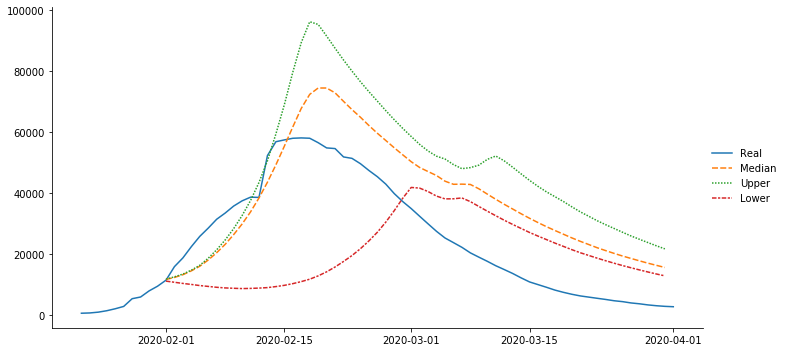

In [95]:
draw_infected(fit, pd.to_datetime('2020-02-01'), 60, 'China')

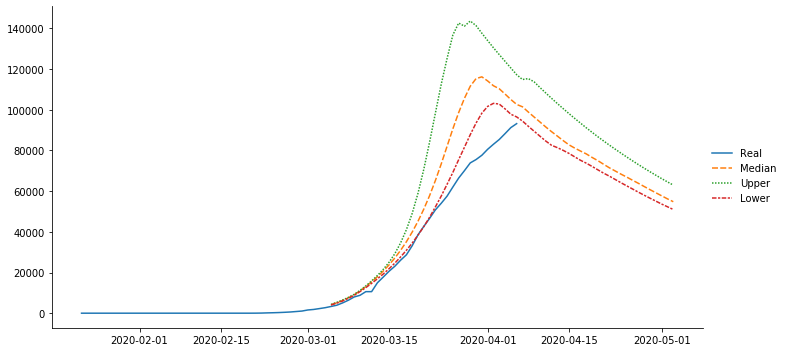

In [96]:
draw_infected(fit, pd.to_datetime('2020-03-5'), 60, 'Italy')

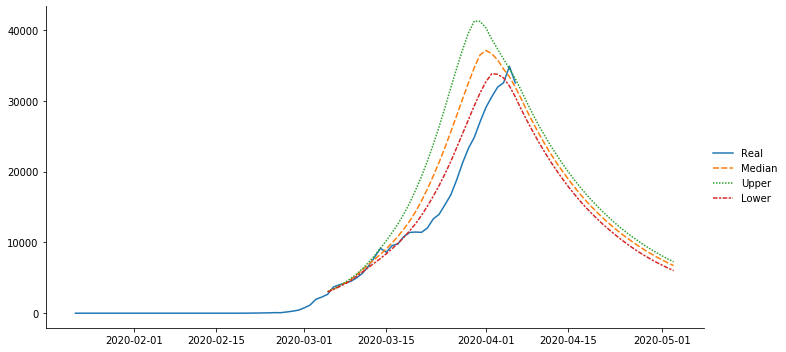

In [97]:
draw_infected(fit, pd.to_datetime('2020-03-05'), 60, 'Iran')

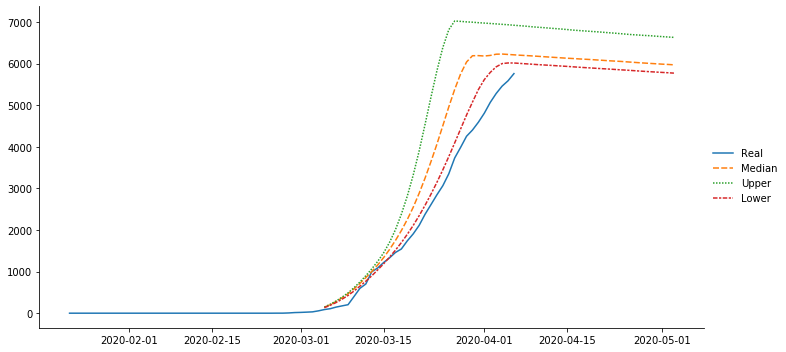

In [98]:
draw_infected(fit, pd.to_datetime('2020-03-05'), 60, 'Norway')

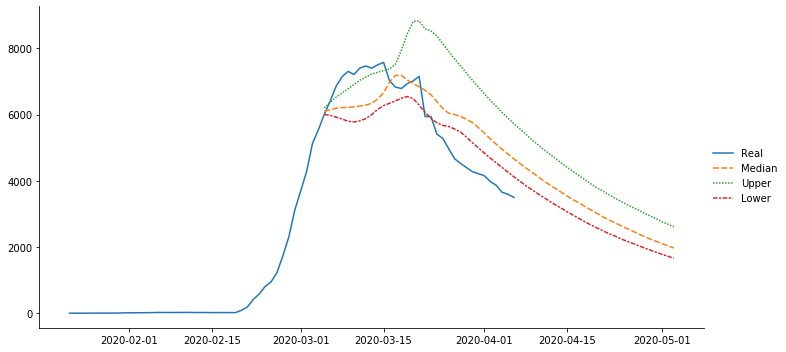

In [99]:
draw_infected(fit, pd.to_datetime('2020-03-05'), 60, 'Korea, South')

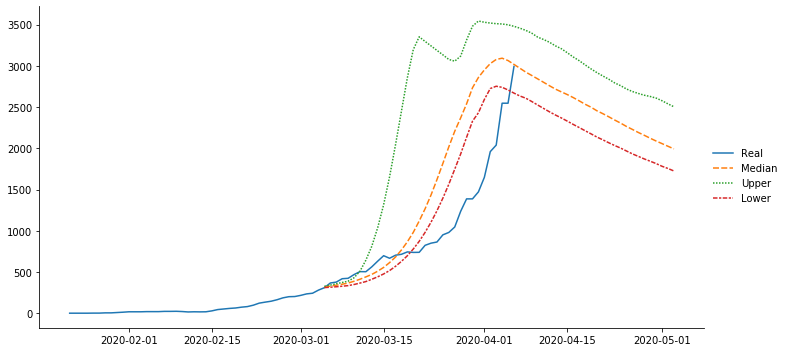

In [100]:
draw_infected(fit, pd.to_datetime('2020-03-05'), 60, 'Japan')

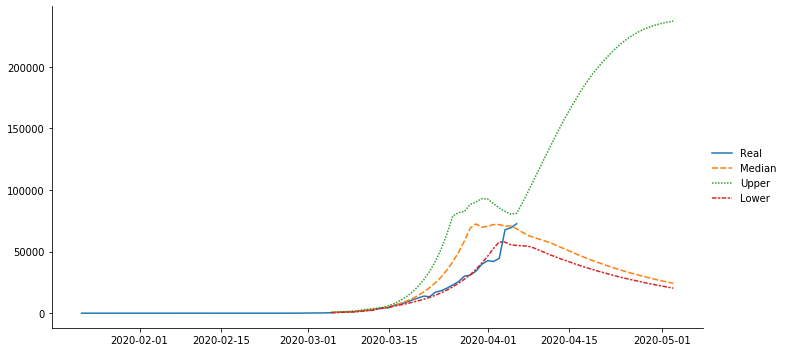

In [101]:
draw_infected(fit, pd.to_datetime('2020-03-05'), 60, 'France')

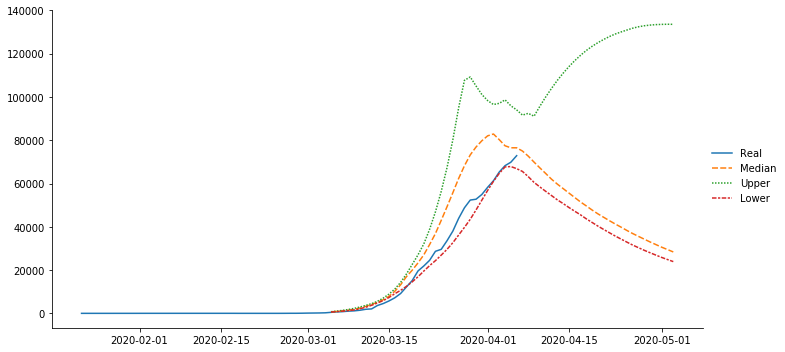

In [102]:
draw_infected(fit, pd.to_datetime('2020-03-05'), 60, 'Germany')

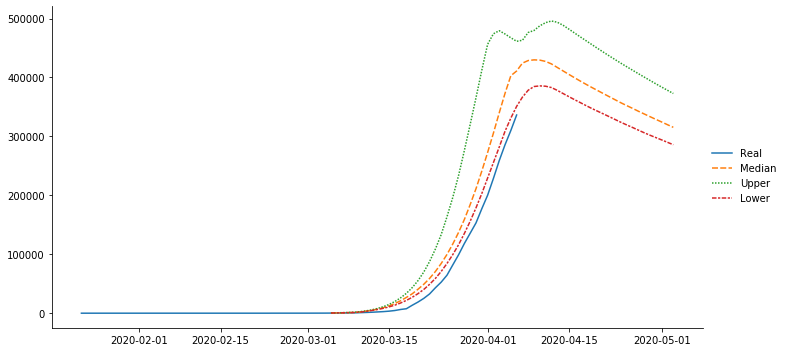

In [103]:
draw_infected(fit, pd.to_datetime('2020-03-05'), 60, 'US')

In [104]:
### Prediction ###

In [105]:
recent = confirmed.index[-1]


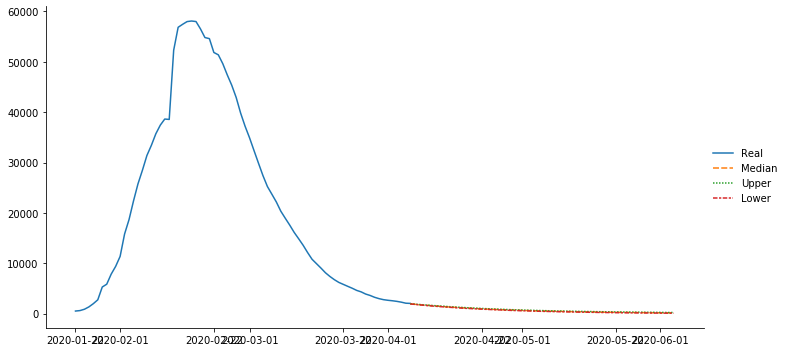

In [106]:
draw_infected(fit, recent, 60, 'China')

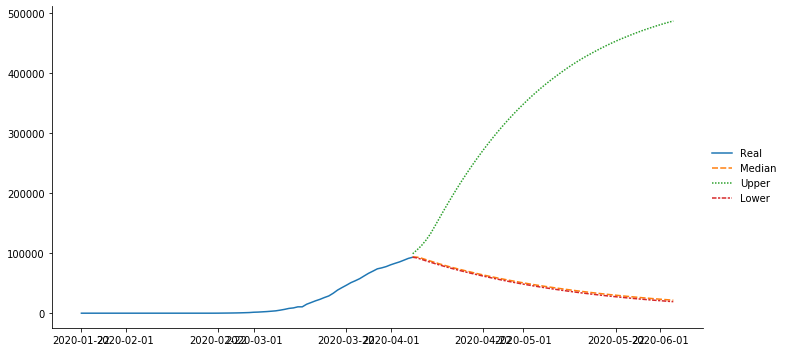

In [107]:
draw_infected(fit, recent, 60, 'Italy')

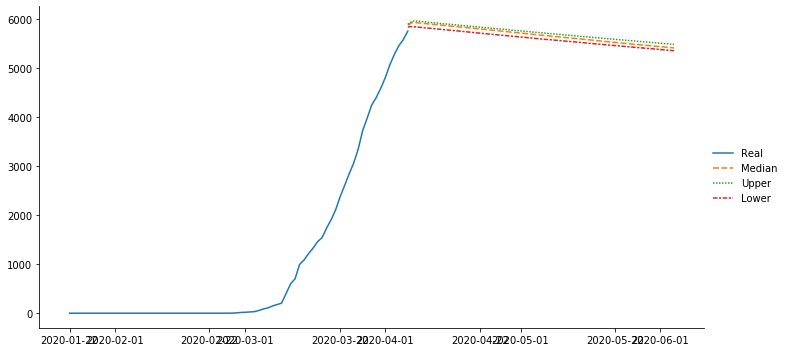

In [108]:
draw_infected(fit, recent, 60, 'Norway')

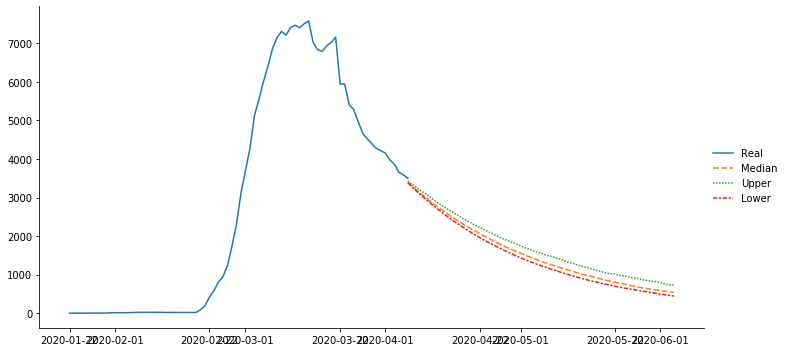

In [109]:
draw_infected(fit, recent, 60, 'Korea, South')

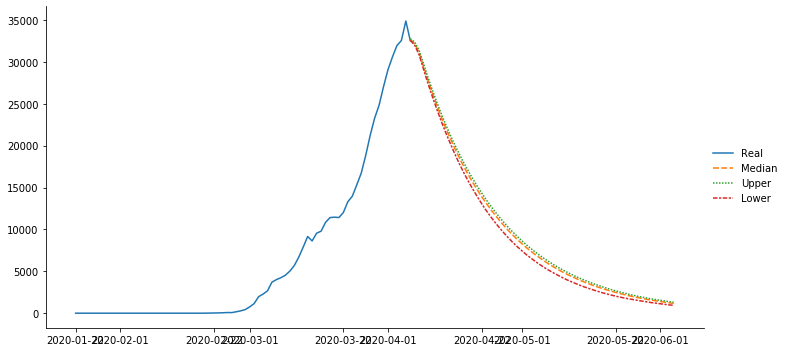

In [110]:
draw_infected(fit, recent, 60, 'Iran')

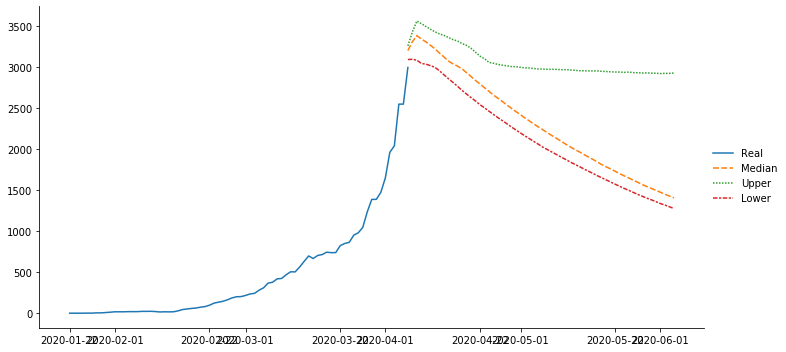

In [111]:
draw_infected(fit, recent, 60, 'Japan')

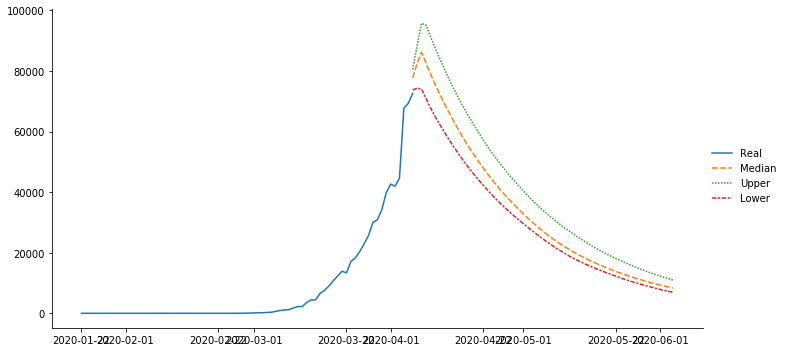

In [112]:
draw_infected(fit, recent, 60, 'France')

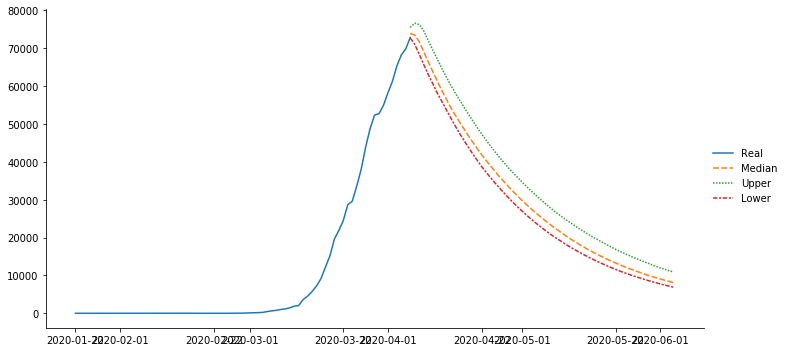

In [113]:
draw_infected(fit, recent, 60, 'Germany')

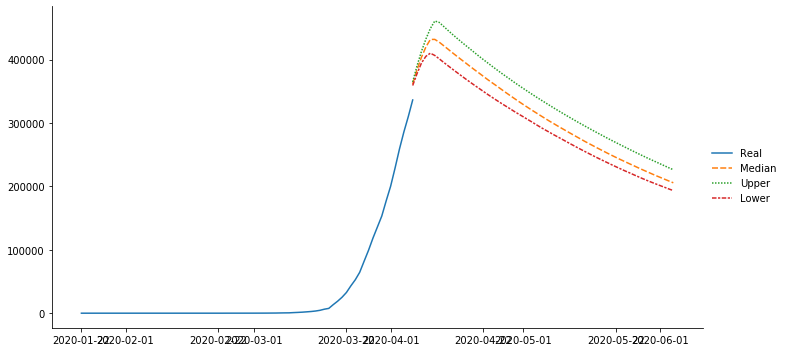

In [114]:
draw_infected(fit, recent, 60, 'US')

In [115]:
def draw_infected_world(fit, start, horizen):
    a_s = fit['a']
    p_s = fit['p']
    c_s = fit['c']
    sigma_S_s = fit['sigma_S']
    sigma_R_s = fit['sigma_R']
    n = a_s.shape[0]
    data = pd.DataFrame()
    cum = []
    for i in range(repeat):
        a = a_s[np.random.randint(n)]
        p = p_s[np.random.randint(n)]
        c = c_s[np.random.randint(n)]
        sigma_S = sigma_S_s[np.random.randint(n)]
        sigma_R = sigma_R_s[np.random.randint(n)]
        infected, cumulative = simulate(a, p, c, sigma_S, sigma_R, start, horizen)
        data = pd.concat([data, infected.sum(axis=1)], axis=1)
        cum.append(cumulative.sum(axis=1).iloc[-1])
    cum = pd.Series(cum)
    graph = pd.DataFrame(index=pd.date_range('2020-01-22', start + pd.Timedelta(days=horizen)))
    real = (confirmed - removed).sum(axis=1)
    median = data.median(axis=1)
    upper = data.quantile(q=0.75, axis=1)
    lower = data.quantile(q=0.25, axis=1)
    graph['Real'] = real
    graph['Median'] = median
    graph['Upper'] = upper
    graph['Lower'] = lower
    sns.relplot(kind="line", ci='sd', data=graph, aspect=2);
    print("Upper:{}, Median:{}, Lower:{}".format(cum.quantile(q=0.75), cum.median(), cum.quantile(q=0.25)))

Upper:6384074.0793221425, Median:1591334.3643535783, Lower:1536255.5377525988


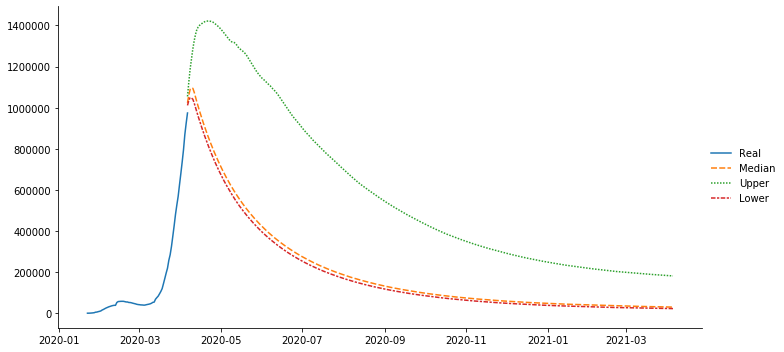

In [116]:
draw_infected_world(fit, recent, 365)

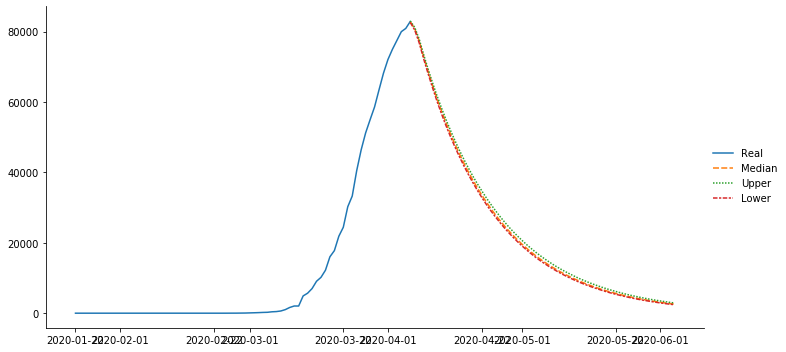

In [117]:
draw_infected(fit, recent, 60, 'Spain')

In [118]:
confirmed.columns

Index(['Algeria', 'Argentina', 'Australia', 'Austria', 'Belgium', 'Brazil',
       'Canada', 'Chile', 'China', 'Colombia', 'Croatia', 'Czechia', 'Denmark',
       'Dominican Republic', 'Ecuador', 'Egypt', 'Estonia', 'Finland',
       'France', 'Germany', 'Greece', 'Iceland', 'India', 'Indonesia', 'Iran',
       'Iraq', 'Ireland', 'Israel', 'Italy', 'Japan', 'Korea, South',
       'Luxembourg', 'Malaysia', 'Mexico', 'Morocco', 'Netherlands',
       'New Zealand', 'Norway', 'Pakistan', 'Panama', 'Peru', 'Philippines',
       'Poland', 'Portugal', 'Qatar', 'Romania', 'Russia', 'Saudi Arabia',
       'Serbia', 'Singapore', 'Slovenia', 'South Africa', 'Spain', 'Sweden',
       'Switzerland', 'Thailand', 'Turkey', 'US', 'Ukraine',
       'United Arab Emirates', 'United Kingdom'],
      dtype='object', name='Country/Region')

In [119]:
pystan.check_hmc_diagnostics(fit)

{'n_eff': False,
 'Rhat': False,
 'divergence': False,
 'treedepth': False,
 'energy': True}

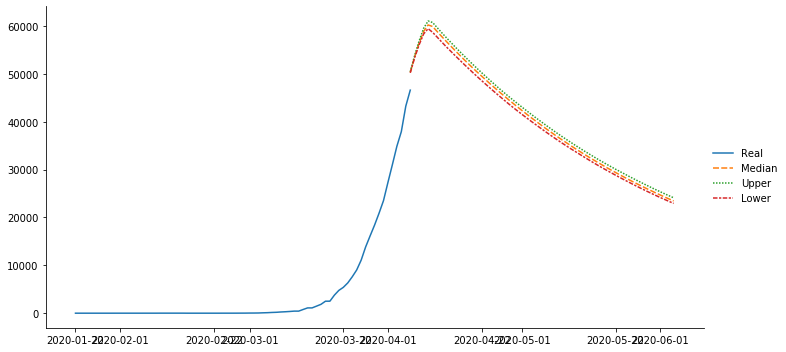

In [120]:
draw_infected(fit, recent, 60, 'United Kingdom')

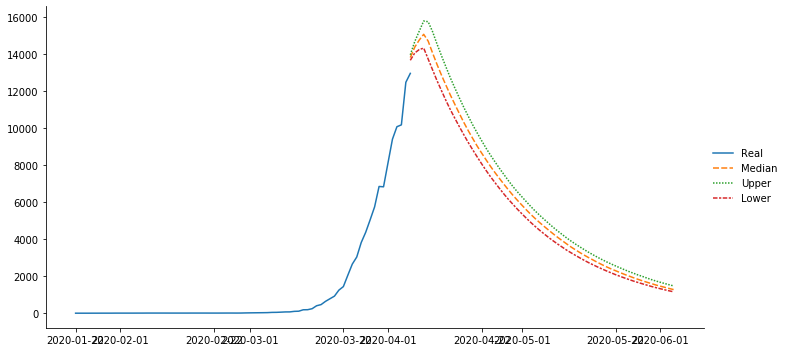

In [121]:
draw_infected(fit, recent, 60, 'Canada')

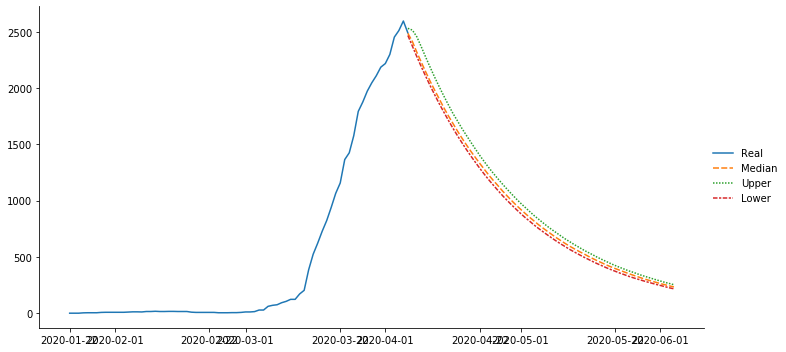

In [122]:
draw_infected(fit, recent, 60, 'Malaysia')

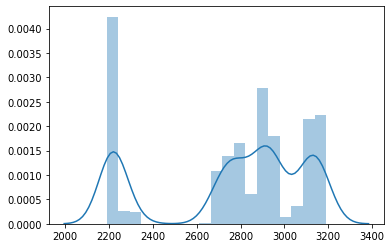

In [123]:
sns.distplot(fit['p'][:,confirmed.columns.get_loc('Japan')])


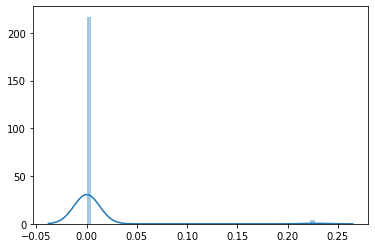

In [124]:
n = confirmed.columns.get_loc('China')
sns.distplot(fit['c'][n,n])

In [125]:
def draw_infected_sums(fit, start, horizen):
    a_s = fit['a']
    p_s = fit['p']
    c_s = fit['c']
    sigma_S_s = fit['sigma_S']
    sigma_R_s = fit['sigma_R']
    n = a_s.shape[0]
    data = pd.DataFrame()
    for i in range(repeat):
        a = a_s[np.random.randint(n)]
        p = p_s[np.random.randint(n)]
        c = c_s[np.random.randint(n)]
        sigma_S = sigma_S_s[np.random.randint(n)]
        sigma_R = sigma_R_s[np.random.randint(n)]
        _, cumulative = simulate(a, p, c, sigma_S, sigma_R, start, horizen)
        data = pd.concat([data, cumulative.iloc[-1]], axis=1)
    melted = pd.melt(data.T).rename(columns={'value':'Infected'})
    my_order = melted.groupby(by=['Country/Region'])['Infected'].median().sort_values(ascending=False).index
    plt.figure(figsize=(10,20))
    sns.boxplot(data=melted, y = 'Country/Region', x='Infected', showfliers=False, order=my_order)
    table = pd.DataFrame({'Lower':data.quantile(q=0.25, axis=1), 
                           'Median':data.median(axis=1), 
                           'Upper':data.quantile(0.75, axis=1)})
    return table

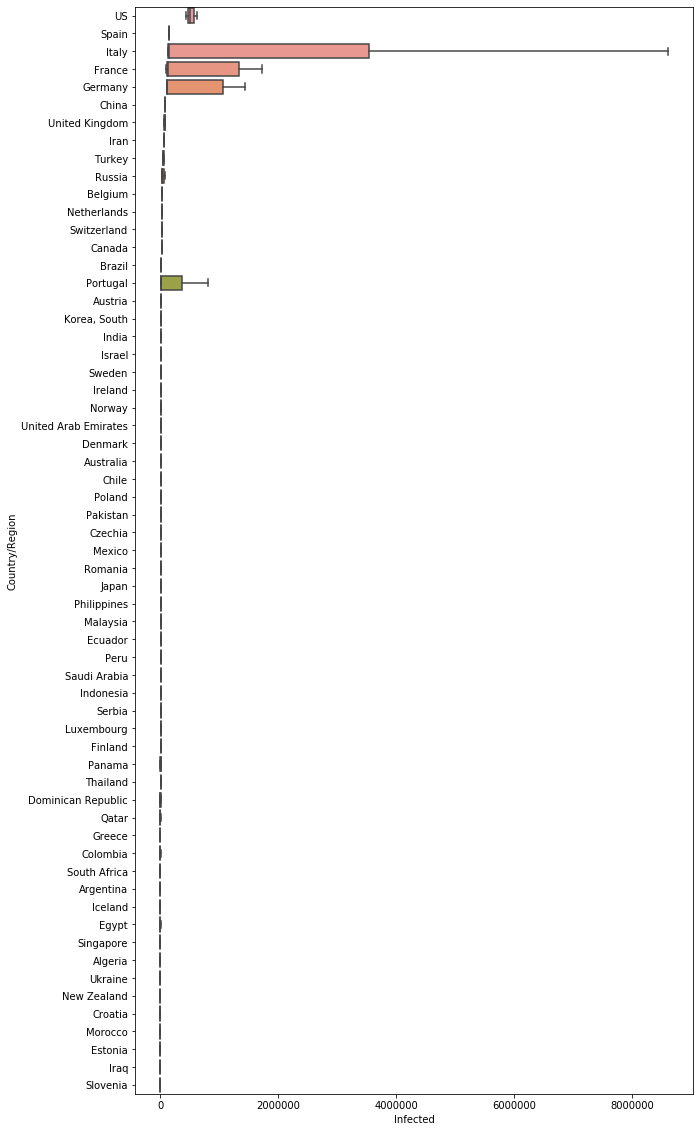

In [126]:
data = draw_infected_sums(fit, recent, 365)

In [127]:
data.loc['Japan']

Lower     3937.111699
Median    4157.457605
Upper     4352.192523
Name: Japan, dtype: float64

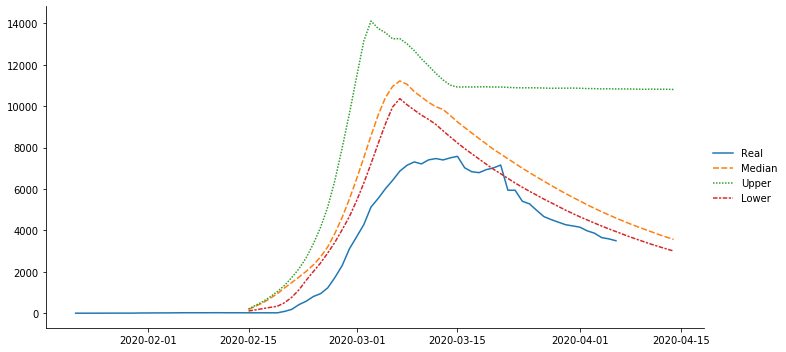

In [128]:
draw_infected(fit, pd.to_datetime('2020-02-15'), 60, 'Korea, South')

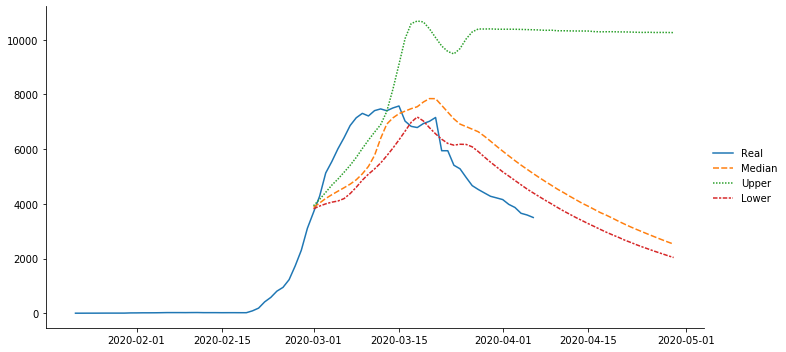

In [129]:
draw_infected(fit, pd.to_datetime('2020-03-01'), 60, 'Korea, South')

In [130]:
df = Confirmed.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))

In [131]:
df['Thailand']

2020-01-22       2
2020-01-23       3
2020-01-24       5
2020-01-25       7
2020-01-26       8
              ... 
2020-04-02    1875
2020-04-03    1978
2020-04-04    2067
2020-04-05    2169
2020-04-06    2220
Name: Thailand, Length: 76, dtype: int64

In [132]:
np.sqrt([1, 1, 1])

array([1., 1., 1.])

In [133]:
np.sqrt([1, 1, 1]) * np.random.randn(3)

array([ 1.16543362, -2.54322134,  0.8257685 ])

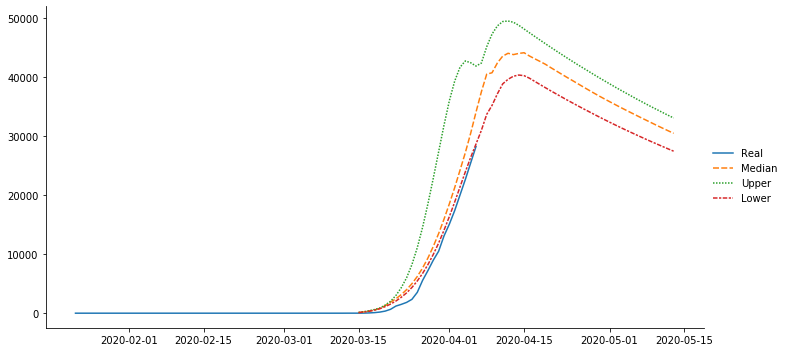

In [134]:
draw_infected(fit, pd.to_datetime('2020-03-15'), 60, 'Turkey')